In [ ]:
from detection.mtcnn_detector import MTCNN_Detector
from core.MTCNN_model import Pnet_model,Rnet_model,Onet_model
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

def main():
    
    if(model_name in ["Pnet","Rnet","Onet"]):
        model[0]=Pnet_model
    if(model_name in ["Rnet","Onet"]):
        model[1]=Rnet_model
    if(model_name=="Onet"):
        model[2]=Onet_model
        
    detector=MTCNN_Detector(model,model_path,batch_size,factor,min_face_size,threshold)
    kaka=[]
    img=cv2.imread(r"C:\Users\friedhelm\Desktop\image00013.jpg") 
    kaka=np.zeros((1,img.shape[0],img.shape[1],img.shape[2]))
    kaka[0,:,:,:]=img

    face_box,_=detector.detect_single_face(img)

    blue = (255, 0, 0) 
    for a in face_box: 
        cv2.rectangle(img,(int(a[0]),int(a[1])), (int(a[2]), int(a[3])),blue,3,8,0)
        
#     cv2.imwrite("C:\\Users\\312\\Desktop\\MTCNN_test_6.jpg",img)
    cv2.imshow("MTCNN_test_1",img)
    cv2.waitKey(0)
#     cv2.destroyAllWindows()
#     plt.imshow(img)    
#     plt.show()    
    
    
if __name__=="__main__":
    

    factor=0.79
    
    model=[None,None,None]
    #原文参数
    threshold=[0.8,0.8,0.6]
    min_face_size=10
    #原文参数
    batch_size=1
    model_name="Rnet"    
    
    model_path=["C:\\Users\\friedhelm\\Desktop\\MTCNN-tensorflow\\model\\Pnet_model\\Pnet_model.ckpt-60000",
                "C:\\Users\\friedhelm\\Desktop\\MTCNN-tensorflow\\model\\Rnet_model\\Rnet_model.ckpt-40000",
                "E:\\friedhelm\\object\\face_detection_MTCNN\\Onet_model\\Onet_model_60000.ckpt",] 
    

    main()
    

INFO:tensorflow:Restoring parameters from C:\Users\friedhelm\Desktop\MTCNN-tensorflow\model\Pnet_model\Pnet_model.ckpt-60000


INFO:tensorflow:Restoring parameters from E:\friedhelm\object\face_detection_MTCNN\Pnet_model\Pnet_model.ckpt-60000
[0.6, 0.474, 0.37446, 0.2958234, 0.233700486, 0.18462338394000002, 0.14585247331260004, 0.11522345391695403, 0.09102652859439368, 0.07191095758957101, 0.056809656495761106, 0.04487962863165128, 0.03545490661900451]


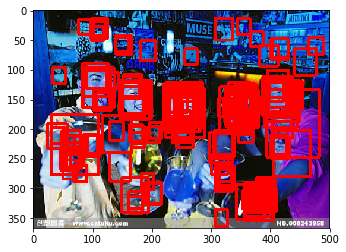

In [5]:
from MTCNN_model import Pnet_model,Rnet_model,Onet_model
import cv2
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tool import IoU,NMS

map_shape=12
stride=2
factor=0.79
threshold=0.8
R_model_path="E:\\friedhelm\\object\\face_detection_MTCNN\\Pnet_model\\Pnet_model.ckpt-60000"

img=cv2.imread(r"C:\Users\312\Desktop\2.jpg") 

R_graph=tf.Graph()
with R_graph.as_default():
    
    images = tf.placeholder(tf.float32)
    label,roi,landmark=Pnet_model(images,1)                    
    R_saver=tf.train.Saver()
    
    with tf.Session() as sess:      
        R_saver.restore(sess,R_model_path)
        
        factor=0.79
        pro=12/20
        scales=[]
        total_box=[]
        score_box=[]
        small=min(img.shape[0:2])*pro
        
        while small>=12:
            scales.append(pro)
            pro*=factor
            small*=factor  
        print(scales)   
         
        boundingBox=[]
        for scale in scales:
            
            crop_img=img    
            left=0
            up=0
            
            img1=cv2.resize(crop_img,((int(crop_img.shape[1]*scale)),(int(crop_img.shape[0]*scale))))
            img2=np.reshape(img1,(-1,img1.shape[0],img1.shape[1],img1.shape[2]))

            a,b,c=sess.run([label,roi,landmark],feed_dict={images:img2})
            a=np.reshape(a,(-1,2)) 
            b=np.reshape(b,(-1,4)) 
            c=np.reshape(c,(-1,10)) 
            for idx,prob in enumerate(a):

                if prob[1]>threshold:
                    biasBox=[]
                    biasBox.extend([float(left*stride)/scale,float(up*stride)/scale, float(left*stride+map_shape)/scale, float(up*stride+map_shape)/scale,prob[1]])
                    biasBox.extend(b[idx])
                    biasBox.extend(c[idx])
                    boundingBox.append(biasBox)

                #防止左越界与下越界
                if (left*stride+map_shape<img1.shape[1]):
                    left+=1
                elif (up*stride+map_shape<img1.shape[0]): 
                    left=0
                    up+=1
                else : break            
            
 
        P_NMS_box=NMS(boundingBox,0.7)
        P_net_box=[]
        for box_ in P_NMS_box:

            box=box_.copy()                        
            if((box[0]<0)|(box[1]<0)|(box[2]>img.shape[1])|(box[3]>img.shape[0])|(box[2]-box[0]<=20)|(box[3]-box[1]<=20)): 
                continue  
            # format of total_box: [x1,y1,x2,y2,score,offset_x1,offset_y1,offset_x2,offset_y2,10*landmark]  

            t_box=[0]*4
            t_w=box[2]-box[0]+1
            t_h=box[3]-box[1]+1

            t_box[0]=box[5]*t_w+box[0]
            t_box[1]=box[6]*t_h+box[1]                     
            t_box[2]=box[7]*t_w+box[2]    
            t_box[3]=box[8]*t_h+box[3]                        
            # 计算真实人脸框

            if((t_box[0]<0)|(t_box[1]<0)|(t_box[2]>img.shape[1])|(t_box[3]>img.shape[0])|(t_box[2]-t_box[0]<=20)|(t_box[3]-t_box[1]<=20)): 
                continue 

            ti_box=t_box.copy()
            ti_box=[int(_) for _ in ti_box]                        

            P_net_box.append(ti_box)


        blue = (255, 0, 0) 
#             featuremap1(sess,graph,img,scales,map_shape,stride,threshold)
        for a in P_net_box: 
#             print(a)
            cv2.rectangle(img,(int(a[0]),int(a[1])), (int(a[2]), int(a[3])),blue,3,8,0)
        plt.imshow(img)    
        plt.show()    

[0.6, 0.474, 0.37446, 0.2958234, 0.233700486, 0.18462338394000002, 0.14585247331260004, 0.11522345391695403, 0.09102652859439368, 0.07191095758957101, 0.056809656495761106, 0.04487962863165128, 0.03545490661900451]
INFO:tensorflow:Restoring parameters from E:\friedhelm\object\face_detection_MTCNN\\Pnet_model\Pnet_model.ckpt-60000


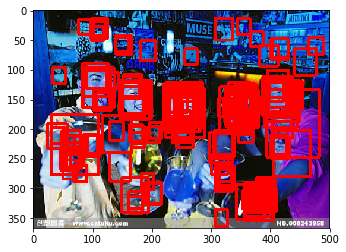

In [4]:
import tensorflow as tf 
import numpy as np
import cv2
import time
from tool import IoU,NMS,featuremap1,featuremap2
import os
from MTCNN_model import Rnet_model
import matplotlib.pyplot as plt
img_size=48
P_map_shape=12
R_map_shape=24
stride=2
factor=0.79
threshold=0.8

P_graph_path='E:\\friedhelm\\object\\face_detection_MTCNN\\\Pnet_model\\Pnet_model.ckpt-60000.meta'
P_model_path='E:\\friedhelm\\object\\face_detection_MTCNN\\\Pnet_model\\Pnet_model.ckpt-60000'

img=cv2.imread(r"C:\Users\312\Desktop\2.jpg") 
# kaka=np.zeros((1,img.shape[0],img.shape[1],img.shape[2]))
# kaka[0,:,:,:]=img

scales=[]
total_box=[]
pro=12/20
small=min(img.shape[0:2])*pro


while small>=12:
    scales.append(pro)
    pro*=factor
    small*=factor 
print(scales)



P_graph=tf.Graph()
with P_graph.as_default():
    P_saver=tf.train.import_meta_graph(P_graph_path)
    with tf.Session(graph=P_graph) as sess:
        P_saver.restore(sess,P_model_path)
        bounding_boxes=featuremap1(sess,P_graph,img,scales,P_map_shape,2,threshold)
        
P_NMS_box=NMS(bounding_boxes,0.7)
P_net_box=[]
for box_ in P_NMS_box:

    box=box_.copy()                        
    if((box[0]<0)|(box[1]<0)|(box[2]>img.shape[1])|(box[3]>img.shape[0])|(box[2]-box[0]<=20)|(box[3]-box[1]<=20)): 
        continue  
    # format of total_box: [x1,y1,x2,y2,score,offset_x1,offset_y1,offset_x2,offset_y2,10*landmark]  

    t_box=[0]*4
    t_w=box[2]-box[0]+1
    t_h=box[3]-box[1]+1

    t_box[0]=box[5]*t_w+box[0]
    t_box[1]=box[6]*t_h+box[1]                     
    t_box[2]=box[7]*t_w+box[2]    
    t_box[3]=box[8]*t_h+box[3]                        
    # 计算真实人脸框

    if((t_box[0]<0)|(t_box[1]<0)|(t_box[2]>img.shape[1])|(t_box[3]>img.shape[0])|(t_box[2]-t_box[0]<=20)|(t_box[3]-t_box[1]<=20)): 
        continue 

    ti_box=t_box.copy()
    ti_box=[int(_) for _ in ti_box]                        

    P_net_box.append(ti_box) 
    
# bounding_boxes=NMS(bounding_boxes,0.7)
blue = (255, 0, 0) 
for a in P_net_box: 
#         print(a)
    cv2.rectangle(img,(int(a[0]),int(a[1])), (int(a[2]), int(a[3])),blue,3,8,0)
plt.imshow(img)    
plt.show()  